## Imports and loading data
Loading the boston dataset directly from its "[source](http://lib.stat.cmu.edu/datasets/boston)".

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
import urllib
data_url = "http://lib.stat.cmu.edu/datasets/boston"

raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
target = raw_df.values[1::2, 2]

file = urllib.request.urlopen(data_url)
columns = list(map(lambda x: x.split(' ')[1], [line.decode('utf-8') for line in file][7:20]))
data = pd.DataFrame(data=data, columns=columns)
data["PRICE"] = target

## Training & Test split

In [3]:
prices = data['PRICE']
features = data.drop('PRICE', axis=1)

X_train, X_test, y_train, y_test = train_test_split(
    features,
    prices, 
    test_size=0.2,
    random_state=10
)

print(
    len(X_train)/len(features),
    len(X_test)/len(features),
    sep='\n'
)

0.7984189723320159
0.2015810276679842


# Multivariable regression

In [4]:
regr = LinearRegression()
regr.fit(X_train,y_train)

pd.DataFrame(data=np.hstack((regr.intercept_,regr.coef_)), index=pd.Index(["Intercept"]).union(X_train.columns, sort=False), columns=['coef'])

,coef
Intercept,36.533051
CRIM,-0.128181
ZN,0.063198
INDUS,-0.007576
CHAS,1.974515
NOX,-16.271989
RM,3.108456
AGE,0.016292
DIS,-1.483014
RAD,0.303988


In [5]:
print("Training data r-squared:", regr.score(X_train, y_train))
print("Test data r-squared:\t", regr.score(X_test, y_test))

Training data r-squared: 0.750121534530608
Test data r-squared:	 0.6709339839115638


# Data transformations

In [6]:
data.skew() # Prices have a skew of 1.11. The ideal should be 0

CRIM       5.223149
ZN         2.225666
INDUS      0.295022
CHAS       3.405904
NOX        0.729308
RM         0.403612
AGE       -0.598963
DIS        1.011781
RAD        1.004815
TAX        0.669956
PTRATIO   -0.802325
B         -2.890374
LSTAT      0.906460
PRICE      1.108098
dtype: float64

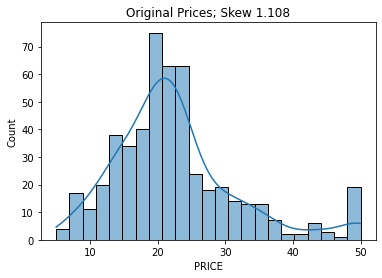

In [7]:
sns.histplot(prices, kde=True)
plt.title(f"Original Prices; Skew {prices.skew():.3f}")
plt.show()

In [8]:
y_log = np.log(data.PRICE)  # Taking the log can help reducing skew sometimes.
y_log

0      3.178054
1      3.072693
2      3.546740
3      3.508556
4      3.589059
         ...   
501    3.109061
502    3.025291
503    3.173878
504    3.091042
505    2.476538
Name: PRICE, Length: 506, dtype: float64

In [9]:
y_log.skew() # Log price skew is nearer 0.

-0.33032129530987864

This plot looks more like a symmetrical normal distribution:

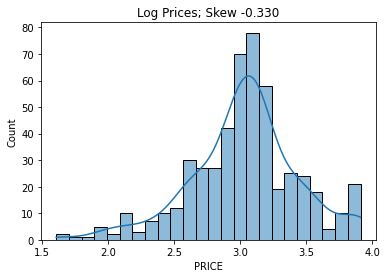

In [10]:
sns.histplot(y_log, kde=True)
plt.title(f"Log Prices; Skew {y_log.skew():.3f}")
plt.show()

Before applying log, the data doesn't look to have a too linear relationship:

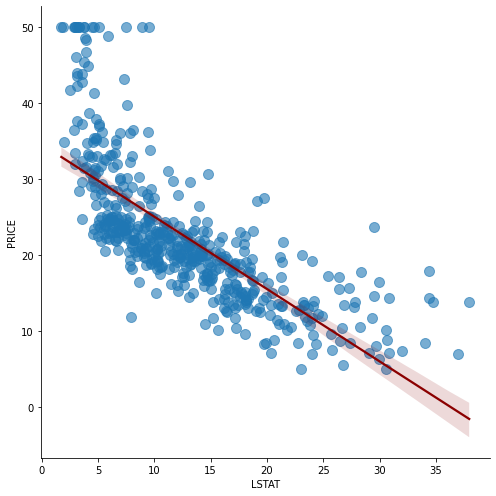

In [11]:
sns.lmplot(x="LSTAT", y="PRICE", data=data, height=7, scatter_kws={'alpha': 0.6,'s': 100}, line_kws={'color':'darkred'})

After applying log, it looks a bit more linear:

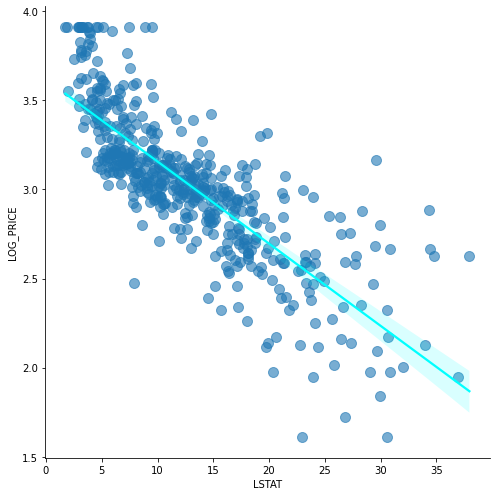

In [12]:
transformed_data= data[["LSTAT"]].copy()
transformed_data['LOG_PRICE']=y_log
sns.lmplot(x="LSTAT", y="LOG_PRICE", data=transformed_data, height=7, scatter_kws={'alpha': 0.6,'s': 100}, line_kws={'color':'cyan'})

# Regression using log prices

In [13]:
prices = np.log(data['PRICE'])
features = data.drop('PRICE', axis=1)

X_train, X_test, y_train, y_test = train_test_split(
    features,
    prices, 
    test_size=0.2,
    random_state=10
)

print(
    f"Train %:\t\t{len(X_train)/len(features)*100:.2f}%",
    f"Test %:\t\t\t{len(X_test)/len(features)*100:.2f}%",
    sep='\n'
)

print(f"Training r-squared:\t{regr.score(X_train, y_train):.3f}")
print(f"Test r-squared:\t\t{regr.score(X_test, y_test):.3f}")

regr = LinearRegression()
regr.fit(X_train,y_train)

pd.DataFrame(data=np.hstack((regr.intercept_,regr.coef_)), index=pd.Index(["Intercept"]).union(X_train.columns, sort=False), columns=['coef'])

Train %:		79.84%
Test %:			20.16%
Training r-squared:	-2504.709
Test r-squared:		-3109.166


,coef
Intercept,4.059944
CRIM,-0.010672
ZN,0.001579
INDUS,0.002030
CHAS,0.080331
NOX,-0.704068
RM,0.073404
AGE,0.000763
DIS,-0.047633
RAD,0.014565


In [14]:
np.e**regr.coef_[3]

1.0836451858696377